#### Selecting Most IMP Features and Mean Encoding Cateogrical Features

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.8MB 57kB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stat
pd.set_option('display.max_columns', None)
%matplotlib inline

### Feature Processing
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from dateutil import relativedelta

### Feature Selection Techniques
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold

### Train Test Split
from sklearn.model_selection import train_test_split

### Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import  XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### Metrics
import sklearn.metrics as metrics

### Hyper Paramter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

### Loading and Saving Model
import pickle

### Ensemble Technique - Combining Multiple models
## We call the algorithms like this way

## Then we use Voting Classifier for ensemble learning:
from sklearn.ensemble import VotingClassifier

from keras import backend as K

##### Handling Missing values in Test data


In [ ]:
test_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
test_data = test_data.drop(['ID','AssetID','Area','City','DisbursalDate','MaturityDAte','AuthDate','DisbursalAmount', 'LTV'],axis=1)

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_data_missing_values_handled.xlsx')
train_data = train_data.drop(['DisbursalDate','MaturityDAte','AuthDate','DisbursalAmount', 'LTV'],axis=1)

In [ ]:
groupby_state_zipcode= train_data.groupby('State')['ZiPCODE'].agg(lambda x:x.value_counts().index[0])
def impute_zipcode(cols):
  zipcode = cols[0]
  state = cols[1]
  if pd.isnull(zipcode):
    return groupby_state_zipcode[state]
  else:
    return zipcode

In [ ]:
test_data['AGE'] =test_data['AGE'].fillna(train_data['AGE'].median())
test_data['MonthlyIncome'] =test_data['MonthlyIncome'].fillna(train_data['MonthlyIncome'].median())
test_data['ManufacturerID'] = test_data['ManufacturerID'].fillna(train_data['ManufacturerID'].mode()[0])
test_data['SEX'] = test_data['SEX'].fillna(train_data['SEX'].value_counts().index[0])
test_data['ZiPCODE'] = test_data[['ZiPCODE','State']].apply(impute_zipcode,axis=1)

In [ ]:
train_data.to_excel('train_missing_values_handled_feat_mean_enc.xlsx')
test_data.to_excel('test_missing_values_handled_feat_mean_enc.xlsx')

#### Mean Encoding

#### Combining Train and Test data for Mean Encoding 

In [ ]:
final_df = pd.concat([train_data,test_data],axis=0)
final_df.shape

(143399, 17)

In [ ]:
final_df.index = range(0,len(final_df))
final_df.head(2)

,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,SEX,AGE,MonthlyIncome,State,ZiPCODE,top_up_class
0,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568.0,21946,M,49.0,35833.33,MADHYA PRADESH,464993.0,1.0
1,Monthly,Advance,Closed,PDC,333,47,485000,350000.0,10500.0,1062.0,34802,M,23.0,666.67,MADHYA PRADESH,466001.0,0.0


In [ ]:
mean_encoding_state = train_data.groupby(['State'])['top_up_class'].mean().to_dict()
final_df['State'] = final_df['State'].map(mean_encoding_state)

In [ ]:
mean_enc_payment = train_data.groupby(['PaymentMode'])['top_up_class'].mean().to_dict()
final_df['PaymentMode'] = final_df['PaymentMode'].map(mean_enc_payment)

In [ ]:
final_df = pd.get_dummies(final_df,drop_first=True)

### Split Dataset in original form

In [ ]:
train_data_final = final_df.iloc[:128654,:]
test_data_final = final_df.iloc[128654:,:]
train_data_final['top_up_class'] = train_data_final['top_up_class'].astype(int)
test_data_final.index = range(0,len(test_data_final))
test_data_final = test_data_final.drop('top_up_class',axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
y = train_data_final['top_up_class']
X = train_data_final.drop('top_up_class',axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 18) (25731, 18) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)
test_final_st = sc.transform(test_data_final)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=100)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

------------------------Logistic Regression------------------------
F1 Score 0.1303
Accuracy Score 0.8269
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       0.00      0.00      0.00      1642
           2       0.00      0.00      0.00       761
           3       0.00      0.00      0.00       683
           4       1.00      0.00      0.00       663
           5       0.20      0.00      0.00       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.29      0.14      0.13     25731
weighted avg       0.71      0.83      0.75     25731



------------------------KNN------------------------
F1 Score 0.1505
Accuracy Score 0.8156
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     21279
           1       0.15      0.02      0.04   

In [ ]:
test_data_final.to_excel('test_final_mean_encoded_final_less_feat.xlsx')
train_data_final.to_excel('train_final_mean_encoded_final_less_feat.xlsx')

#### Removing Zip Code Column

In [ ]:
train_data_final_no_zip = train_data_final.drop('ZiPCODE',axis=1)
test_data_final_no_zip = test_data_final.drop('ZiPCODE',axis=1)
print(train_data_final_no_zip.shape,test_data_final_no_zip.shape)

(128654, 18) (14745, 17)


In [ ]:
y = train_data_final_no_zip['top_up_class']
X = train_data_final_no_zip.drop('top_up_class',axis=1)
X.head()

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
0,0.186877,1,48,450000,275000.0,24000.0,1568.0,21946,49.0,35833.33,0.425187,0,1,0,1,1,1
1,0.255776,333,47,485000,350000.0,10500.0,1062.0,34802,23.0,666.67,0.425187,0,1,0,0,1,1
2,0.668451,1,68,690000,519728.0,38300.0,1060.0,127335,39.0,45257.00,0.425187,0,0,1,1,0,1
3,0.168888,125,48,480000,400000.0,11600.0,1060.0,25094,24.0,20833.33,0.425187,0,1,0,0,1,1
4,0.168888,152,44,619265,440000.0,15000.0,1046.0,21853,56.0,27313.67,0.269824,0,1,0,1,1,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 17) (25731, 17) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=100)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

------------------------Logistic Regression------------------------
F1 Score 0.1303
Accuracy Score 0.8268
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       0.00      0.00      0.00      1642
           2       0.00      0.00      0.00       761
           3       0.00      0.00      0.00       683
           4       1.00      0.00      0.00       663
           5       0.20      0.00      0.00       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.29      0.14      0.13     25731
weighted avg       0.71      0.83      0.75     25731



------------------------KNN------------------------
F1 Score 0.1506
Accuracy Score 0.8158
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     21279
           1       0.15      0.02      0.04   

### Adding Zip Code AND Replacing with mode values of State

In [ ]:
test_data.head()

,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,SEX,AGE,MonthlyIncome,State,ZiPCODE
0,Monthly,Advance,Closed,PDC_E,2,46,480000,365000.0,1000.0,1046.0,22354,M,50.0,32069.00,MADHYA PRADESH,473001.0
1,Monthly,Advance,Closed,PDC,2,45,480000,285000.0,9300.0,1046.0,22354,M,35.0,25000.00,MADHYA PRADESH,473001.0
2,Quatrly,Arrear,Closed,PDC,2,48,580000,400000.0,35800.0,1060.0,65929,M,37.0,23333.33,MADHYA PRADESH,473001.0
3,Half Yearly,Arrear,Closed,Billed,154,36,725000,500000.0,52000.0,1049.0,68597,M,55.0,91666.67,CHATTISGARH,493558.0
4,Quatrly,Arrear,Closed,PDC,194,48,617000,400000.0,35400.0,1049.0,38493,M,48.0,12500.00,ORISSA,754137.0


In [ ]:
mean_enc_payment = train_data.groupby(['ZiPCODE'])['top_up_class'].mean().to_dict()
test_data['ZiPCODE_Mean'] = test_data['ZiPCODE'].map(mean_enc_payment)

In [ ]:
test_data[test_data['ZiPCODE_Mean'].isnull()]

,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,SEX,AGE,MonthlyIncome,State,ZiPCODE,ZiPCODE_Mean
0,Monthly,Advance,Closed,PDC_E,2,46,480000,365000.0,1000.0,1046.0,22354,M,50.0,32069.00,MADHYA PRADESH,473001.0,NaN
1,Monthly,Advance,Closed,PDC,2,45,480000,285000.0,9300.0,1046.0,22354,M,35.0,25000.00,MADHYA PRADESH,473001.0,NaN
2,Quatrly,Arrear,Closed,PDC,2,48,580000,400000.0,35800.0,1060.0,65929,M,37.0,23333.33,MADHYA PRADESH,473001.0,NaN
5,Quatrly,Arrear,Active,Direct Debit,262,48,636000,400000.0,35300.0,1046.0,73027,F,49.0,41666.67,ORISSA,755045.0,NaN
8,Quatrly,Arrear,Closed,PDC_E,231,48,570876,400000.0,37000.0,1019.0,22934,M,46.0,22000.00,WEST BENGAL,713519.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14737,Monthly,Arrear,Active,Direct Debit,396,29,350000,240972.4,10100.0,1568.0,138500,M,46.0,58333.33,UTTAR PRADESH,245101.0,NaN
14738,Half Yearly,Arrear,Closed,ECS,399,60,580000,522638.0,78959.0,1568.0,86345,M,21.0,113958.33,RAJASTHAN,331402.0,NaN
14739,Quatrly,Arrear,Active,Direct Debit,424,24,340000,200582.0,29581.0,1568.0,134311,M,39.0,52083.33,HARYANA,132101.0,NaN
14743,Monthly,Arrear,Closed,PDC_E,246,12,400000,280000.0,25350.0,1046.0,63565,M,40.0,35833.33,RAJASTHAN,335001.0,NaN


In [ ]:
test_data[test_data['ZiPCODE_Mean'].isnull()]['State'].unique()

array(['MADHYA PRADESH', 'ORISSA', 'WEST BENGAL', 'HARYANA', 'PUNJAB',
       'UTTAR PRADESH', 'UTTARAKHAND', 'RAJASTHAN', 'ANDHRA PRADESH',
       'GUJARAT', 'MAHARASHTRA', 'CHATTISGARH', 'KARNATAKA', 'TELANGANA',
       'JHARKHAND', 'DELHI', 'BIHAR'], dtype=object)

In [ ]:
mean_enc_payment = train_data.groupby(['ZiPCODE'])['top_up_class'].mean().to_dict()
train_data['ZiPCODE_Mean'] = train_data['ZiPCODE'].map(mean_enc_payment)

In [ ]:
train_data.head()

,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,SEX,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,ZiPCODE_Mean
0,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,21946,M,49,35833.33,MADHYA PRADESH,464993,1,0.250000
1,Monthly,Advance,Closed,PDC,333,47,485000,350000.0,10500.0,1062,34802,M,23,666.67,MADHYA PRADESH,466001,0,0.360000
2,Quatrly,Arrear,Active,Direct Debit,1,68,690000,519728.0,38300.0,1060,127335,M,39,45257.00,MADHYA PRADESH,462030,6,0.652174
3,Monthly,Advance,Closed,Billed,125,48,480000,400000.0,11600.0,1060,25094,M,24,20833.33,MADHYA PRADESH,473335,1,0.322034
4,Monthly,Arrear,Closed,Billed,152,44,619265,440000.0,15000.0,1046,21853,M,56,27313.67,CHATTISGARH,495442,2,0.500000


In [ ]:
new_zip_mean = train_data[train_data['State'].isin(test_data[test_data['ZiPCODE_Mean'].isnull()]['State'].unique())]

In [ ]:
new_zip_mean

,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,SEX,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,ZiPCODE_Mean
0,Monthly,Arrear,Closed,PDC_E,1,48,450000,275000.0,24000.0,1568,21946,M,49,35833.33,MADHYA PRADESH,464993,1,0.250000
1,Monthly,Advance,Closed,PDC,333,47,485000,350000.0,10500.0,1062,34802,M,23,666.67,MADHYA PRADESH,466001,0,0.360000
2,Quatrly,Arrear,Active,Direct Debit,1,68,690000,519728.0,38300.0,1060,127335,M,39,45257.00,MADHYA PRADESH,462030,6,0.652174
3,Monthly,Advance,Closed,Billed,125,48,480000,400000.0,11600.0,1060,25094,M,24,20833.33,MADHYA PRADESH,473335,1,0.322034
4,Monthly,Arrear,Closed,Billed,152,44,619265,440000.0,15000.0,1046,21853,M,56,27313.67,CHATTISGARH,495442,2,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128649,Half Yearly,Arrear,Closed,Direct Debit,424,24,470000,265601.0,76800.0,1568,48879,M,25,65333.33,HARYANA,131403,3,2.333333
128650,Half Yearly,Arrear,Closed,Direct Debit,424,24,460000,275630.0,80100.0,1568,48879,M,25,83333.33,HARYANA,131403,0,2.333333
128651,Monthly,Arrear,Active,Direct Debit,424,23,545000,300733.0,15277.0,1568,44118,M,36,248500.00,HARYANA,131024,0,0.000000
128652,Half Yearly,Arrear,Active,Direct Debit,424,35,350000,250962.0,74341.0,1568,48879,M,37,84500.00,HARYANA,131103,0,0.000000


In [ ]:
mean_zip_null= new_zip_mean.groupby('State')['ZiPCODE_Mean'].median()
mean_zip_null

State
ANDHRA PRADESH    0.666667
BIHAR             0.500000
CHATTISGARH       0.199275
DELHI             0.000000
GUJARAT           0.250000
HARYANA           0.500000
JHARKHAND         0.000000
KARNATAKA         0.405405
MADHYA PRADESH    0.370000
MAHARASHTRA       0.333333
ORISSA            0.287179
PUNJAB            0.284091
RAJASTHAN         0.124069
TELANGANA         0.711111
UTTAR PRADESH     0.266667
UTTARAKHAND       0.400000
WEST BENGAL       0.304348
Name: ZiPCODE_Mean, dtype: float64

In [ ]:
def impute_zipcode(cols):
  zipcode = cols[0]
  state = cols[1]
  if pd.isnull(zipcode):
    return mean_zip_null[state]
  else:
    return zipcode

In [ ]:
test_data['ZiPCODE_Mean'] = test_data[['ZiPCODE_Mean','State']].apply(impute_zipcode,axis=1)
test_data.head(50)

,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,SEX,AGE,MonthlyIncome,State,ZiPCODE,ZiPCODE_Mean
0,Monthly,Advance,Closed,PDC_E,2,46,480000,365000.0,1000.0,1046.0,22354,M,50.0,32069.00,MADHYA PRADESH,473001.0,0.370000
1,Monthly,Advance,Closed,PDC,2,45,480000,285000.0,9300.0,1046.0,22354,M,35.0,25000.00,MADHYA PRADESH,473001.0,0.370000
2,Quatrly,Arrear,Closed,PDC,2,48,580000,400000.0,35800.0,1060.0,65929,M,37.0,23333.33,MADHYA PRADESH,473001.0,0.370000
3,Half Yearly,Arrear,Closed,Billed,154,36,725000,500000.0,52000.0,1049.0,68597,M,55.0,91666.67,CHATTISGARH,493558.0,0.264901
4,Quatrly,Arrear,Closed,PDC,194,48,617000,400000.0,35400.0,1049.0,38493,M,48.0,12500.00,ORISSA,754137.0,0.000000
5,Quatrly,Arrear,Active,Direct Debit,262,48,636000,400000.0,35300.0,1046.0,73027,F,49.0,41666.67,ORISSA,755045.0,0.287179
6,Monthly,Arrear,Closed,ECS,194,48,598000,350000.0,10261.0,1049.0,38493,M,31.0,33333.33,ORISSA,753001.0,0.000000
7,Monthly,Advance,Closed,PDC,9,47,565931,350000.0,10200.0,1049.0,23954,M,53.0,14166.67,WEST BENGAL,713103.0,0.625000
8,Quatrly,Arrear,Closed,PDC_E,231,48,570876,400000.0,37000.0,1019.0,22934,M,46.0,22000.00,WEST BENGAL,713519.0,0.304348
9,Monthly,Advance,Closed,PDC_E,10,47,569500,390000.0,14000.0,1049.0,20610,M,25.0,25000.00,WEST BENGAL,722136.0,0.000000


In [ ]:
test_data_final.head()

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
0,0.186877,2,46,480000,365000.0,1000.0,1046.0,22354,50.0,32069.00,0.425187,473001.0,0,1,0,0,1,1
1,0.255776,2,45,480000,285000.0,9300.0,1046.0,22354,35.0,25000.00,0.425187,473001.0,0,1,0,0,1,1
2,0.255776,2,48,580000,400000.0,35800.0,1060.0,65929,37.0,23333.33,0.425187,473001.0,0,0,1,1,1,1
3,0.168888,154,36,725000,500000.0,52000.0,1049.0,68597,55.0,91666.67,0.269824,493558.0,1,0,0,1,1,1
4,0.255776,194,48,617000,400000.0,35400.0,1049.0,38493,48.0,12500.00,0.430084,754137.0,0,0,1,1,1,1


In [ ]:
test_data_final['ZiPCODE_f'] = list(test_data['ZiPCODE_Mean'])
test_data_final 

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M,ZiPCODE_f
0,0.186877,2,46,480000,365000.0,1000.0,1046.0,22354,50.0,32069.00,0.425187,473001.0,0,1,0,0,1,1,0.370000
1,0.255776,2,45,480000,285000.0,9300.0,1046.0,22354,35.0,25000.00,0.425187,473001.0,0,1,0,0,1,1,0.370000
2,0.255776,2,48,580000,400000.0,35800.0,1060.0,65929,37.0,23333.33,0.425187,473001.0,0,0,1,1,1,1,0.370000
3,0.168888,154,36,725000,500000.0,52000.0,1049.0,68597,55.0,91666.67,0.269824,493558.0,1,0,0,1,1,1,0.264901
4,0.255776,194,48,617000,400000.0,35400.0,1049.0,38493,48.0,12500.00,0.430084,754137.0,0,0,1,1,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14740,0.255776,143,35,530016,419616.0,14723.0,1046.0,22094,40.0,35833.33,0.533554,122001.0,0,1,0,1,1,1,0.287500
14741,0.255776,32,36,595000,446500.0,15491.0,2721.0,61196,40.0,35833.33,0.436771,560020.0,0,1,0,1,1,1,0.000000
14742,0.255776,32,36,595000,446500.0,15491.0,2721.0,61196,40.0,35833.33,0.436771,560020.0,0,1,0,1,1,1,0.000000
14743,0.186877,246,12,400000,280000.0,25350.0,1046.0,63565,40.0,35833.33,0.185561,335001.0,0,1,0,1,1,1,0.124069


In [ ]:
test_data_final = test_data_final.drop('ZiPCODE',axis=1)
test_data_final.head()

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M,ZiPCODE_f
0,0.186877,2,46,480000,365000.0,1000.0,1046.0,22354,50.0,32069.00,0.425187,0,1,0,0,1,1,0.370000
1,0.255776,2,45,480000,285000.0,9300.0,1046.0,22354,35.0,25000.00,0.425187,0,1,0,0,1,1,0.370000
2,0.255776,2,48,580000,400000.0,35800.0,1060.0,65929,37.0,23333.33,0.425187,0,0,1,1,1,1,0.370000
3,0.168888,154,36,725000,500000.0,52000.0,1049.0,68597,55.0,91666.67,0.269824,1,0,0,1,1,1,0.264901
4,0.255776,194,48,617000,400000.0,35400.0,1049.0,38493,48.0,12500.00,0.430084,0,0,1,1,1,1,0.000000


In [ ]:
test_data_final.columns

Index(['PaymentMode', 'BranchID', 'Tenure', 'AssetCost', 'AmountFinance',
       'EMI', 'ManufacturerID', 'SupplierID', 'AGE', 'MonthlyIncome', 'State',
       'Frequency_Half Yearly', 'Frequency_Monthly', 'Frequency_Quatrly',
       'InstlmentMode_Arrear', 'LoanStatus_Closed', 'SEX_M', 'ZiPCODE_f'],
      dtype='object')

In [ ]:
test_data_final.columns = ['PaymentMode', 'BranchID', 'Tenure', 'AssetCost', 'AmountFinance',
       'EMI', 'ManufacturerID', 'SupplierID', 'AGE', 'MonthlyIncome', 'State',
       'Frequency_Half Yearly', 'Frequency_Monthly', 'Frequency_Quatrly',
       'InstlmentMode_Arrear', 'LoanStatus_Closed', 'SEX_M', 'ZiPCODE']

test_data_final.head()

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M,ZiPCODE
0,0.186877,2,46,480000,365000.0,1000.0,1046.0,22354,50.0,32069.00,0.425187,0,1,0,0,1,1,0.370000
1,0.255776,2,45,480000,285000.0,9300.0,1046.0,22354,35.0,25000.00,0.425187,0,1,0,0,1,1,0.370000
2,0.255776,2,48,580000,400000.0,35800.0,1060.0,65929,37.0,23333.33,0.425187,0,0,1,1,1,1,0.370000
3,0.168888,154,36,725000,500000.0,52000.0,1049.0,68597,55.0,91666.67,0.269824,1,0,0,1,1,1,0.264901
4,0.255776,194,48,617000,400000.0,35400.0,1049.0,38493,48.0,12500.00,0.430084,0,0,1,1,1,1,0.000000


In [ ]:
test_data_final.isnull().sum()

PaymentMode              0
BranchID                 0
Tenure                   0
AssetCost                0
AmountFinance            0
EMI                      0
ManufacturerID           0
SupplierID               0
AGE                      0
MonthlyIncome            0
State                    0
Frequency_Half Yearly    0
Frequency_Monthly        0
Frequency_Quatrly        0
InstlmentMode_Arrear     0
LoanStatus_Closed        0
SEX_M                    0
ZiPCODE                  0
dtype: int64

In [ ]:
test_data_final.to_excel('test_data_mean_enc_with_zip.xlsx')

In [ ]:
test_data_final = test_data_final[['PaymentMode', 'BranchID', 'Tenure', 'AssetCost', 'AmountFinance',
       'EMI', 'ManufacturerID', 'SupplierID', 'AGE', 'MonthlyIncome', 'State','ZiPCODE',
       'Frequency_Half Yearly', 'Frequency_Monthly', 'Frequency_Quatrly',
       'InstlmentMode_Arrear', 'LoanStatus_Closed', 'SEX_M']]

test_data_final.head(2)

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
0,0.186877,2,46,480000,365000.0,1000.0,1046.0,22354,50.0,32069.0,0.425187,0.37,0,1,0,0,1,1
1,0.255776,2,45,480000,285000.0,9300.0,1046.0,22354,35.0,25000.0,0.425187,0.37,0,1,0,0,1,1


In [ ]:
train_data_final['ZiPCODE'] = train_data_final['ZiPCODE'].map(train_data_final.groupby(['ZiPCODE'])['top_up_class'].mean().to_dict())
train_data_final.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
0,0.186877,1,48,450000,275000.0,24000.0,1568.0,21946,49.0,35833.33,0.425187,0.250000,1,0,1,0,1,1,1
1,0.255776,333,47,485000,350000.0,10500.0,1062.0,34802,23.0,666.67,0.425187,0.360000,0,0,1,0,0,1,1
2,0.668451,1,68,690000,519728.0,38300.0,1060.0,127335,39.0,45257.00,0.425187,0.652174,6,0,0,1,1,0,1
3,0.168888,125,48,480000,400000.0,11600.0,1060.0,25094,24.0,20833.33,0.425187,0.322034,1,0,1,0,0,1,1
4,0.168888,152,44,619265,440000.0,15000.0,1046.0,21853,56.0,27313.67,0.269824,0.500000,2,0,1,0,1,1,1


In [ ]:
test_data_final.shape , train_data_final.shape

((14745, 18), (128654, 19))

In [ ]:
train_data_final.to_excel('train_data_updated.xlsx')
test_data_final.to_excel('test_data_updated.xlsx')

In [ ]:
y = train_data_final['top_up_class']
X = train_data_final.drop('top_up_class',axis=1)
X.head()

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
0,0.186877,1,48,450000,275000.0,24000.0,1568.0,21946,49.0,35833.33,0.425187,0.250000,0,1,0,1,1,1
1,0.255776,333,47,485000,350000.0,10500.0,1062.0,34802,23.0,666.67,0.425187,0.360000,0,1,0,0,1,1
2,0.668451,1,68,690000,519728.0,38300.0,1060.0,127335,39.0,45257.00,0.425187,0.652174,0,0,1,1,0,1
3,0.168888,125,48,480000,400000.0,11600.0,1060.0,25094,24.0,20833.33,0.425187,0.322034,0,1,0,0,1,1
4,0.168888,152,44,619265,440000.0,15000.0,1046.0,21853,56.0,27313.67,0.269824,0.500000,0,1,0,1,1,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 18) (25731, 18) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=100)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

------------------------Logistic Regression------------------------
F1 Score 0.1642
Accuracy Score 0.8271
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       0.00      0.00      0.00      1642
           2       0.00      0.00      0.00       761
           3       0.17      0.01      0.02       683
           4       0.50      0.04      0.07       663
           5       0.33      0.07      0.12       502
           6       0.50      0.02      0.04       201

    accuracy                           0.83     25731
   macro avg       0.33      0.16      0.16     25731
weighted avg       0.71      0.83      0.75     25731



------------------------KNN------------------------
F1 Score 0.1778
Accuracy Score 0.8154
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     21279
           1       0.16      0.03      0.05   

### Hyper parameter tunning

KNN

In [ ]:
model_knn_final = KNeighborsClassifier(n_neighbors=1 , weights ='distance' ,metric='minkowski')
model_knn_final = model_knn_final.fit(X_train_st,y_train)

y_pred = model_knn_final.predict(X_test_st)
print('------------------------KNN MODEL------------------------')
print('F1 Score', metrics.f1_score(y_test,y_pred,average='macro'))
print('Accuracy Score', metrics.accuracy_score(y_test,y_pred))
print('Classification report \n ')
print(metrics.classification_report(y_test,y_pred))
print('\n')

------------------------KNN MODEL------------------------
F1 Score 0.21205134413305635
Accuracy Score 0.7210368815825269
Classification report 
 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     21279
           1       0.13      0.13      0.13      1642
           2       0.09      0.09      0.09       761
           3       0.11      0.11      0.11       683
           4       0.11      0.10      0.10       663
           5       0.13      0.12      0.13       502
           6       0.08      0.07      0.08       201

    accuracy                           0.72     25731
   macro avg       0.21      0.21      0.21     25731
weighted avg       0.72      0.72      0.72     25731





Random Forest 

In [ ]:
model_rf_final = RandomForestClassifier(max_depth=30,max_features='auto',min_samples_leaf=5,min_samples_split=15,n_estimators=100)
model_rf_final = model_rf_final.fit(X_train_st,y_train)

y_pred = model_rf_final.predict(X_test_st)
print('------------------------RF MODEL------------------------')
print('F1 Score', metrics.f1_score(y_test,y_pred,average='macro'))
print('Accuracy Score', metrics.accuracy_score(y_test,y_pred))
print('Classification report \n ')
print(metrics.classification_report(y_test,y_pred))
print('\n')

------------------------RF MODEL------------------------
F1 Score 0.14127087242950553
Accuracy Score 0.8272900392522639
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       0.67      0.00      0.00      1642
           2       0.00      0.00      0.00       761
           3       0.25      0.00      0.01       683
           4       0.60      0.00      0.01       663
           5       0.47      0.03      0.06       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.40      0.15      0.14     25731
weighted avg       0.76      0.83      0.75     25731





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DT

In [ ]:
model_dt_final = DecisionTreeClassifier(criterion='entropy',max_depth=30)
model_dt_final = model_dt_final.fit(X_train_st,y_train)

y_pred = model_dt_final.predict(X_test_st)
print('------------------------DT MODEL------------------------')
print('F1 Score', metrics.f1_score(y_test,y_pred,average='macro'))
print('Accuracy Score', metrics.accuracy_score(y_test,y_pred))
print('Classification report \n ')
print(metrics.classification_report(y_test,y_pred))
print('\n')

------------------------DT MODEL------------------------
F1 Score 0.2168346724619814
Accuracy Score 0.7140414286269481
Classification report 
 
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     21279
           1       0.14      0.15      0.14      1642
           2       0.08      0.08      0.08       761
           3       0.12      0.13      0.12       683
           4       0.11      0.11      0.11       663
           5       0.13      0.13      0.13       502
           6       0.08      0.09      0.09       201

    accuracy                           0.71     25731
   macro avg       0.21      0.22      0.22     25731
weighted avg       0.72      0.71      0.72     25731





Combined Model

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=30)
knn = KNeighborsClassifier(n_neighbors=1 , weights ='distance' ,metric='minkowski')
rf=RandomForestClassifier()
lr = LogisticRegression()
gbm = GradientBoostingClassifier()
lgbm = LGBMClassifier()

Ens = VotingClassifier( 
    estimators= [('DecisionTreeClassifier',dt),('KNeighborsClassifier',knn),('RandomForestClassifier',rf),
                 ('LogisticRegression',lr),('GradientBoostingClassifier',gbm),('LGBMClassifier',lgbm)
                 ],voting='soft')

## Training the Ensemble learning:
Ens= Ens.fit(X_train_st , y_train)

y_pred = Ens.predict(X_test_st)
print('------------------------COMBINED MODEL------------------------')
print('F1 Score', metrics.f1_score(y_test,y_pred,average='macro'))
print('Accuracy Score', metrics.accuracy_score(y_test,y_pred))
print('Classification report \n ')
print(metrics.classification_report(y_test,y_pred))
print('\n')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


------------------------COMBINED MODEL------------------------
F1 Score 0.1860730172738891
Accuracy Score 0.8262795849364579
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      0.99      0.91     21279
           1       0.42      0.02      0.04      1642
           2       0.11      0.00      0.01       761
           3       0.32      0.05      0.08       683
           4       0.36      0.04      0.07       663
           5       0.39      0.08      0.13       502
           6       0.35      0.04      0.08       201

    accuracy                           0.83     25731
   macro avg       0.40      0.17      0.19     25731
weighted avg       0.75      0.83      0.76     25731





### ANN

In [ ]:
import tensorflow as tf
y_train_encc = tf.keras.utils.to_categorical(y_train, 7)
y_test_encc = tf.keras.utils.to_categorical(y_test, 7)

print(y_train_encc.shape,y_test_encc.shape)

(102923, 7) (25731, 7)


In [ ]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout


# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 50, kernel_initializer = 'he_uniform',activation='relu',input_dim = 18))

# Adding the second hidden layer
classifier.add(Dense(units = 25, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the third hidden layer
classifier.add(Dense(units = 50, kernel_initializer = 'he_uniform',activation='relu'))
# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'he_uniform',activation='softmax'))

# Compiling the ANN
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[get_f1])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                950       
_________________________________________________________________
dense_5 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 357       
Total params: 3,882
Trainable params: 3,882
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_history=classifier.fit(X_train_st, y_train_encc,validation_split=0.20, batch_size = 10, epochs = 25)

Epoch 1/25
8234/8234 [==============================] - 22s 3ms/step - loss: 0.5926 - get_f1: 0.8280 - val_loss: 0.6065 - val_get_f1: 0.8334
Epoch 2/25
8234/8234 [==============================] - 22s 3ms/step - loss: 0.5919 - get_f1: 0.8284 - val_loss: 0.6167 - val_get_f1: 0.8315
Epoch 3/25
8234/8234 [==============================] - 22s 3ms/step - loss: 0.5928 - get_f1: 0.8282 - val_loss: 0.6109 - val_get_f1: 0.8336
Epoch 4/25
8234/8234 [==============================] - 22s 3ms/step - loss: 0.5945 - get_f1: 0.8283 - val_loss: 0.6010 - val_get_f1: 0.8327
Epoch 5/25
8234/8234 [==============================] - 22s 3ms/step - loss: 0.5931 - get_f1: 0.8277 - val_loss: 0.6011 - val_get_f1: 0.8318
Epoch 6/25
8234/8234 [==============================] - 22s 3ms/step - loss: 0.5925 - get_f1: 0.8281 - val_loss: 0.6053 - val_get_f1: 0.8324
Epoch 7/25
8234/8234 [==============================] - 23s 3ms/step - loss: 0.5931 - get_f1: 0.8281 - val_loss: 0.5975 - val_get_f1: 0.8339
Epoch 8/25
82

In [ ]:
y_pred = classifier.predict(X_test_st)
y_pred_final = np.argmax(y_pred,axis=1)
print('------------------------ANN MODEL------------------------')
print('F1 Score', metrics.f1_score(y_test,y_pred_final,average='macro'))
print('Accuracy Score', metrics.accuracy_score(y_test,y_pred_final))
print('Classification report \n ')
print(metrics.classification_report(y_test,y_pred_final))
print('\n')

------------------------ANN MODEL------------------------
F1 Score 0.16519985631371537
Accuracy Score 0.8269014029769539
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       1.00      0.00      0.00      1642
           2       0.00      0.00      0.00       761
           3       0.21      0.01      0.02       683
           4       0.39      0.01      0.02       663
           5       0.42      0.05      0.08       502
           6       0.39      0.07      0.13       201

    accuracy                           0.83     25731
   macro avg       0.46      0.16      0.17     25731
weighted avg       0.78      0.83      0.75     25731





### Final Model For Submissions

In [ ]:
train_data_final.head()

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
0,0.186877,1,48,450000,275000.0,24000.0,1568.0,21946,49.0,35833.33,0.425187,0.250000,1,0,1,0,1,1,1
1,0.255776,333,47,485000,350000.0,10500.0,1062.0,34802,23.0,666.67,0.425187,0.360000,0,0,1,0,0,1,1
2,0.668451,1,68,690000,519728.0,38300.0,1060.0,127335,39.0,45257.00,0.425187,0.652174,6,0,0,1,1,0,1
3,0.168888,125,48,480000,400000.0,11600.0,1060.0,25094,24.0,20833.33,0.425187,0.322034,1,0,1,0,0,1,1
4,0.168888,152,44,619265,440000.0,15000.0,1046.0,21853,56.0,27313.67,0.269824,0.500000,2,0,1,0,1,1,1


In [ ]:
test_data_final.head()

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
0,0.186877,2,46,480000,365000.0,1000.0,1046.0,22354,50.0,32069.00,0.425187,0.370000,0,1,0,0,1,1
1,0.255776,2,45,480000,285000.0,9300.0,1046.0,22354,35.0,25000.00,0.425187,0.370000,0,1,0,0,1,1
2,0.255776,2,48,580000,400000.0,35800.0,1060.0,65929,37.0,23333.33,0.425187,0.370000,0,0,1,1,1,1
3,0.168888,154,36,725000,500000.0,52000.0,1049.0,68597,55.0,91666.67,0.269824,0.264901,1,0,0,1,1,1
4,0.255776,194,48,617000,400000.0,35400.0,1049.0,38493,48.0,12500.00,0.430084,0.000000,0,0,1,1,1,1


In [ ]:
print(train_data_final.shape,test_data_final.shape)

(128654, 19) (14745, 18)


In [ ]:
y = train_data_final['top_up_class']
X = train_data_final.drop('top_up_class',axis=1)
display(X.head())
print(y)

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
0,0.186877,1,48,450000,275000.0,24000.0,1568.0,21946,49.0,35833.33,0.425187,0.250000,0,1,0,1,1,1
1,0.255776,333,47,485000,350000.0,10500.0,1062.0,34802,23.0,666.67,0.425187,0.360000,0,1,0,0,1,1
2,0.668451,1,68,690000,519728.0,38300.0,1060.0,127335,39.0,45257.00,0.425187,0.652174,0,0,1,1,0,1
3,0.168888,125,48,480000,400000.0,11600.0,1060.0,25094,24.0,20833.33,0.425187,0.322034,0,1,0,0,1,1
4,0.168888,152,44,619265,440000.0,15000.0,1046.0,21853,56.0,27313.67,0.269824,0.500000,0,1,0,1,1,1


0         1
1         0
2         6
3         1
4         2
         ..
128649    3
128650    0
128651    0
128652    0
128653    0
Name: top_up_class, Length: 128654, dtype: int64


In [ ]:
print(X.shape,y.shape)

(128654, 18) (128654,)


In [ ]:
sc = StandardScaler()
X_st = sc.fit_transform(X)
test_final_st = sc.transform(test_data_final)

KNN 

In [ ]:
model_knn_final_submit = KNeighborsClassifier(n_neighbors=1 , weights ='distance' ,metric='minkowski')
model_knn_final_submit = model_knn_final_submit.fit(X_st,y)

y_pred = model_knn_final_submit.predict(test_final_st)
top_up_class_label_dict = {
    0:'No Top-up Service',
    1:' > 48 Months',
    2:'36-48 Months',
    3:'24-30 Months',
    4:'30-36 Months',
    5:'18-24 Months',
    6:'12-18 Months'
}
submission_df = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
submission_df['Pred'] = list(y_pred)
sub = submission_df[['ID','Pred']]
sub.columns = ['ID','Top-up Month']
sub['Top-up Month_Final'] = sub['Top-up Month'].map(top_up_class_label_dict)
sub = sub.drop('Top-up Month',axis=1)
sub.columns = ['ID','Top-up Month']
sub['Top-up Month'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No Top-up Service    12467
 > 48 Months          1019
36-48 Months           428
30-36 Months           321
24-30 Months           279
18-24 Months           165
12-18 Months            66
Name: Top-up Month, dtype: int64

In [ ]:
sub.to_csv('submit_knn_updated_imp.csv',index=False)

DT

In [ ]:
model_dt_final_submit = DecisionTreeClassifier(criterion='entropy',max_depth=30)
model_dt_final_submit = model_dt_final_submit.fit(X_st,y)

y_pred = model_dt_final_submit.predict(test_final_st)
top_up_class_label_dict = {
    0:'No Top-up Service',
    1:' > 48 Months',
    2:'36-48 Months',
    3:'24-30 Months',
    4:'30-36 Months',
    5:'18-24 Months',
    6:'12-18 Months'
}
submission_df = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
submission_df['Pred'] = list(y_pred)
sub = submission_df[['ID','Pred']]
sub.columns = ['ID','Top-up Month']
sub['Top-up Month_Final'] = sub['Top-up Month'].map(top_up_class_label_dict)
sub = sub.drop('Top-up Month',axis=1)
sub.columns = ['ID','Top-up Month']
sub['Top-up Month'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No Top-up Service    11953
 > 48 Months          1186
36-48 Months           513
24-30 Months           387
30-36 Months           377
18-24 Months           231
12-18 Months            98
Name: Top-up Month, dtype: int64

In [ ]:
sub.to_csv('submit_dt_updated_imp.csv',index=False)

### RF

In [ ]:
model_rf_final_submit = RandomForestClassifier()
model_rf_final_submit = model_rf_final_submit.fit(X_st,y)

y_pred = model_rf_final_submit.predict(test_final_st)
top_up_class_label_dict = {
    0:'No Top-up Service',
    1:' > 48 Months',
    2:'36-48 Months',
    3:'24-30 Months',
    4:'30-36 Months',
    5:'18-24 Months',
    6:'12-18 Months'
}
submission_df = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
submission_df['Pred'] = list(y_pred)
sub = submission_df[['ID','Pred']]
sub.columns = ['ID','Top-up Month']
sub['Top-up Month_Final'] = sub['Top-up Month'].map(top_up_class_label_dict)
sub = sub.drop('Top-up Month',axis=1)
sub.columns = ['ID','Top-up Month']
sub['Top-up Month'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No Top-up Service    14706
 > 48 Months            19
30-36 Months            11
18-24 Months             5
24-30 Months             4
Name: Top-up Month, dtype: int64

In [ ]:
sub.to_csv('submit_rf_updated_imp.csv',index=False)

GBM

In [ ]:
model_rf_final_submit = GradientBoostingClassifier()
model_rf_final_submit = model_rf_final_submit.fit(X_st,y)

y_pred = model_rf_final_submit.predict(test_final_st)
top_up_class_label_dict = {
    0:'No Top-up Service',
    1:' > 48 Months',
    2:'36-48 Months',
    3:'24-30 Months',
    4:'30-36 Months',
    5:'18-24 Months',
    6:'12-18 Months'
}
submission_df = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
submission_df['Pred'] = list(y_pred)
sub = submission_df[['ID','Pred']]
sub.columns = ['ID','Top-up Month']
sub['Top-up Month_Final'] = sub['Top-up Month'].map(top_up_class_label_dict)
sub = sub.drop('Top-up Month',axis=1)
sub.columns = ['ID','Top-up Month']
sub['Top-up Month'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No Top-up Service    14713
30-36 Months            14
 > 48 Months             8
18-24 Months             5
12-18 Months             4
24-30 Months             1
Name: Top-up Month, dtype: int64

In [ ]:
sub.to_csv('submit_GBM_updated_imp.csv',index=False)

LGBM

In [ ]:
model_rf_final_submit = LGBMClassifier()
model_rf_final_submit = model_rf_final_submit.fit(X_st,y)

y_pred = model_rf_final_submit.predict(test_final_st)
top_up_class_label_dict = {
    0:'No Top-up Service',
    1:' > 48 Months',
    2:'36-48 Months',
    3:'24-30 Months',
    4:'30-36 Months',
    5:'18-24 Months',
    6:'12-18 Months'
}
submission_df = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
submission_df['Pred'] = list(y_pred)
sub = submission_df[['ID','Pred']]
sub.columns = ['ID','Top-up Month']
sub['Top-up Month_Final'] = sub['Top-up Month'].map(top_up_class_label_dict)
sub = sub.drop('Top-up Month',axis=1)
sub.columns = ['ID','Top-up Month']
sub['Top-up Month'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No Top-up Service    14705
 > 48 Months            11
30-36 Months            11
12-18 Months             8
24-30 Months             5
18-24 Months             3
36-48 Months             2
Name: Top-up Month, dtype: int64

In [ ]:
sub.to_csv('submit_LGBM_updated_imp.csv',index=False)

Combined

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=30)
knn = KNeighborsClassifier(n_neighbors=1 , weights ='distance' ,metric='minkowski')
rf=RandomForestClassifier()
gbm = GradientBoostingClassifier()
lgbm = LGBMClassifier()

Ens = VotingClassifier( 
    estimators= [('DecisionTreeClassifier',dt),('KNeighborsClassifier',knn),('RandomForestClassifier',rf),
                 ('GradientBoostingClassifier',gbm),('LGBMClassifier',lgbm)
                 ],voting='soft')

## Training the Ensemble learning:
Ens= Ens.fit(X_st , y)

y_pred = Ens.predict(test_final_st)
top_up_class_label_dict = {
    0:'No Top-up Service',
    1:' > 48 Months',
    2:'36-48 Months',
    3:'24-30 Months',
    4:'30-36 Months',
    5:'18-24 Months',
    6:'12-18 Months'
}
submission_df = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_Data.xlsx')
submission_df['Pred'] = list(y_pred)
sub = submission_df[['ID','Pred']]
sub.columns = ['ID','Top-up Month']
sub['Top-up Month_Final'] = sub['Top-up Month'].map(top_up_class_label_dict)
sub = sub.drop('Top-up Month',axis=1)
sub.columns = ['ID','Top-up Month']
sub['Top-up Month'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No Top-up Service    14490
 > 48 Months           120
30-36 Months            43
24-30 Months            40
36-48 Months            24
18-24 Months            22
12-18 Months             6
Name: Top-up Month, dtype: int64

In [ ]:
sub.to_csv('submit_combined_updated_imp.csv',index=False)

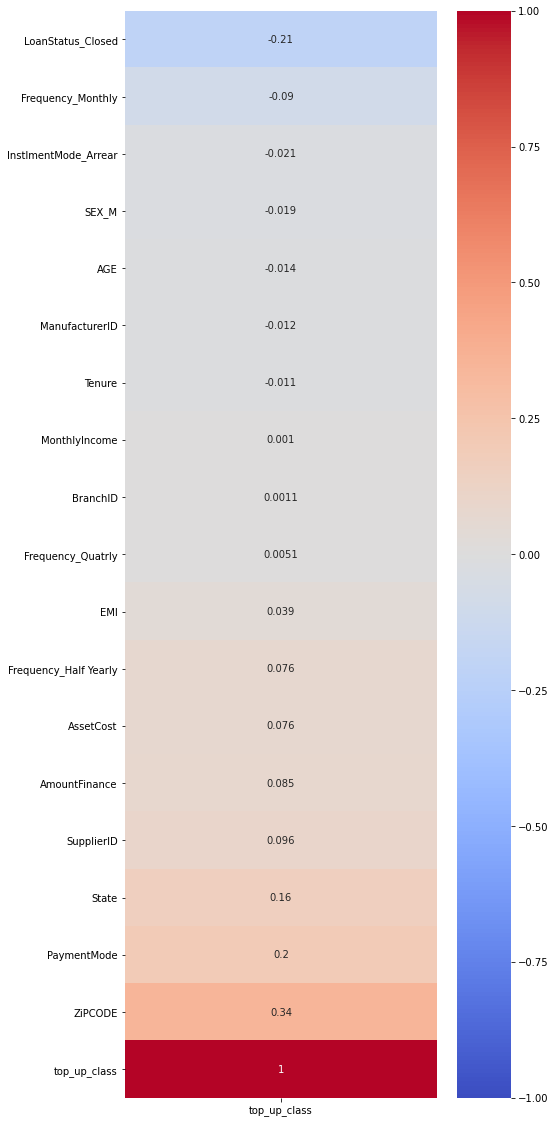

In [ ]:
plt.figure(figsize=(7, 20))
sns.heatmap(train_data_final.corr()[['top_up_class']].sort_values(by='top_up_class'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 

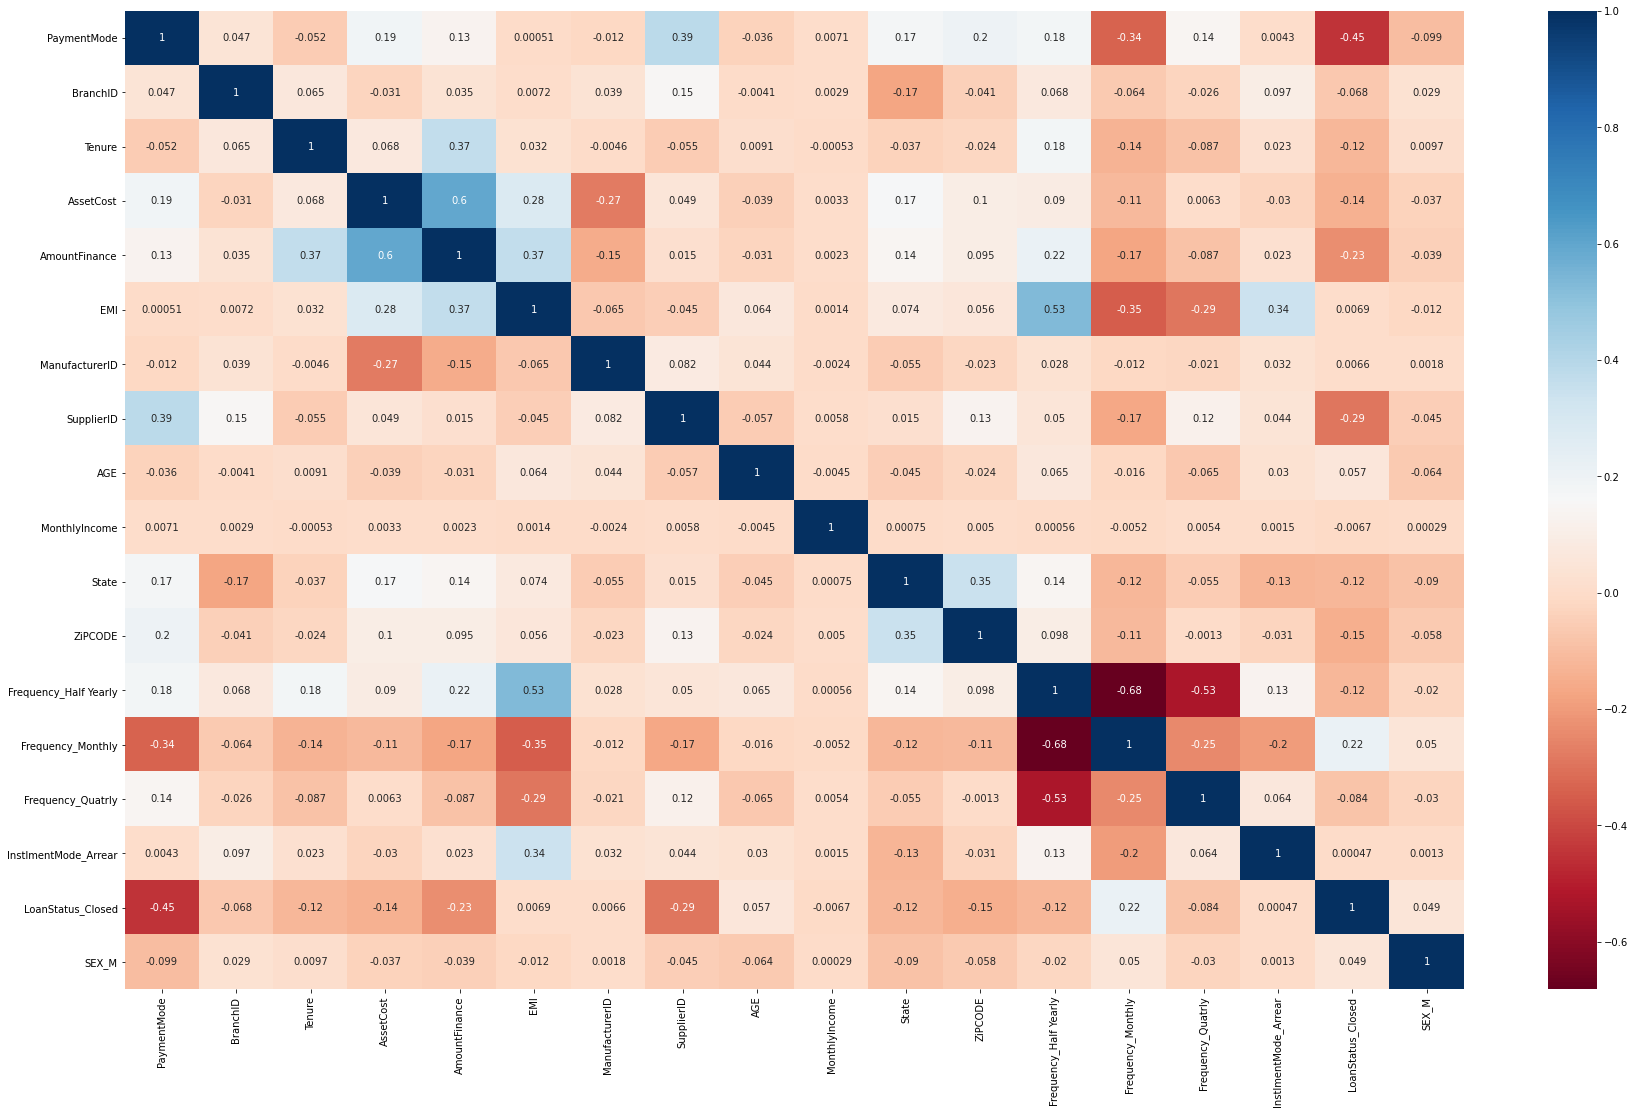

In [ ]:
dataset_only_independent = train_data_final.copy()
dataset_only_independent = dataset_only_independent.drop(['top_up_class'],axis=1)
dataset_only_independent.head(2)
plt.figure(figsize=(30, 18))
sns.heatmap(dataset_only_independent.corr(),annot=True,cmap='RdBu')
plt.show()

---------------------

##### Only 20 imp features 

#### OG Zip

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_final_mean_encoded_final_less_feat.xlsx')
test_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_final_mean_encoded_final_less_feat.xlsx')
print(train_data.shape,test_data.shape)

(128654, 20) (14745, 19)


In [ ]:
train_data = train_data.iloc[:,1:]
test_data = test_data.iloc[:,1:]
print(train_data.shape,test_data.shape)

(128654, 19) (14745, 18)


### Imp Features

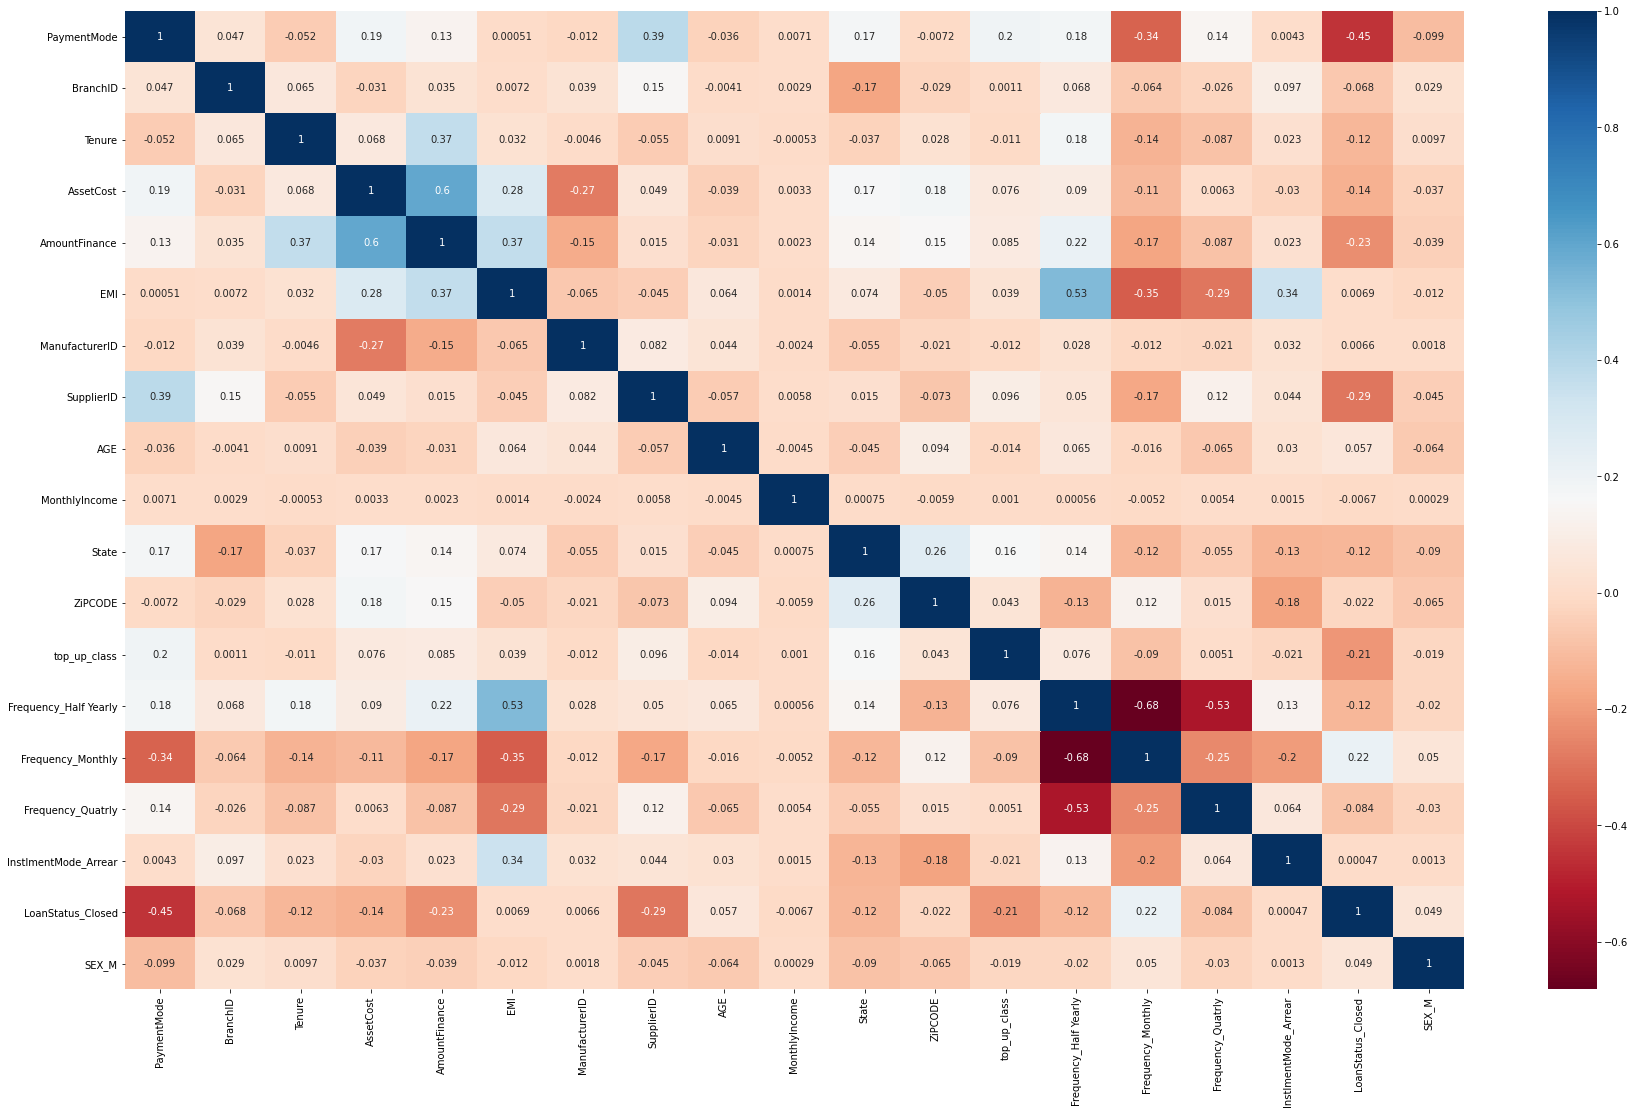

In [ ]:
dataset = train_data.copy()
plt.figure(figsize=(30, 18))
sns.heatmap(dataset.corr(),annot=True,cmap='RdBu')
plt.show()

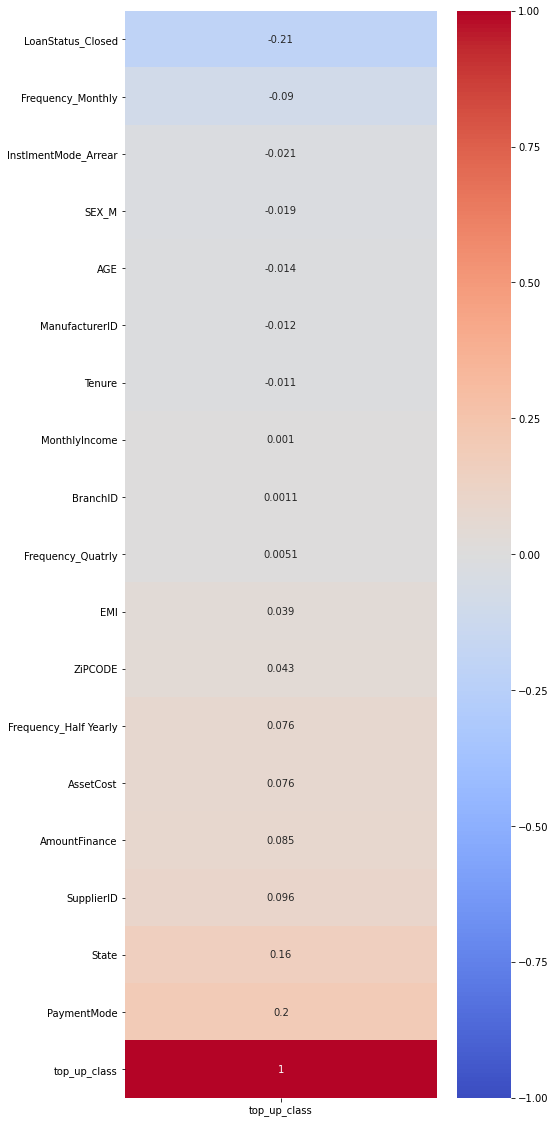

In [ ]:
plt.figure(figsize=(7, 20))
sns.heatmap(dataset.corr()[['top_up_class']].sort_values(by='top_up_class'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 

In [ ]:
dataset_only_independent = dataset.copy()
dataset_only_independent = dataset_only_independent.drop(['top_up_class'],axis=1)
y_og_values = dataset['top_up_class']
model_feature_Selection = ExtraTreesClassifier()
model_feature_Selection.fit(dataset_only_independent,y_og_values)
print(model_feature_Selection.feature_importances_)

[0.04752319 0.05654422 0.07022003 0.10047127 0.10078879 0.10747361
 0.05418228 0.07851369 0.10782823 0.11477841 0.02657519 0.10522277
 0.00206626 0.00204789 0.00154043 0.00355766 0.01350654 0.00715954]


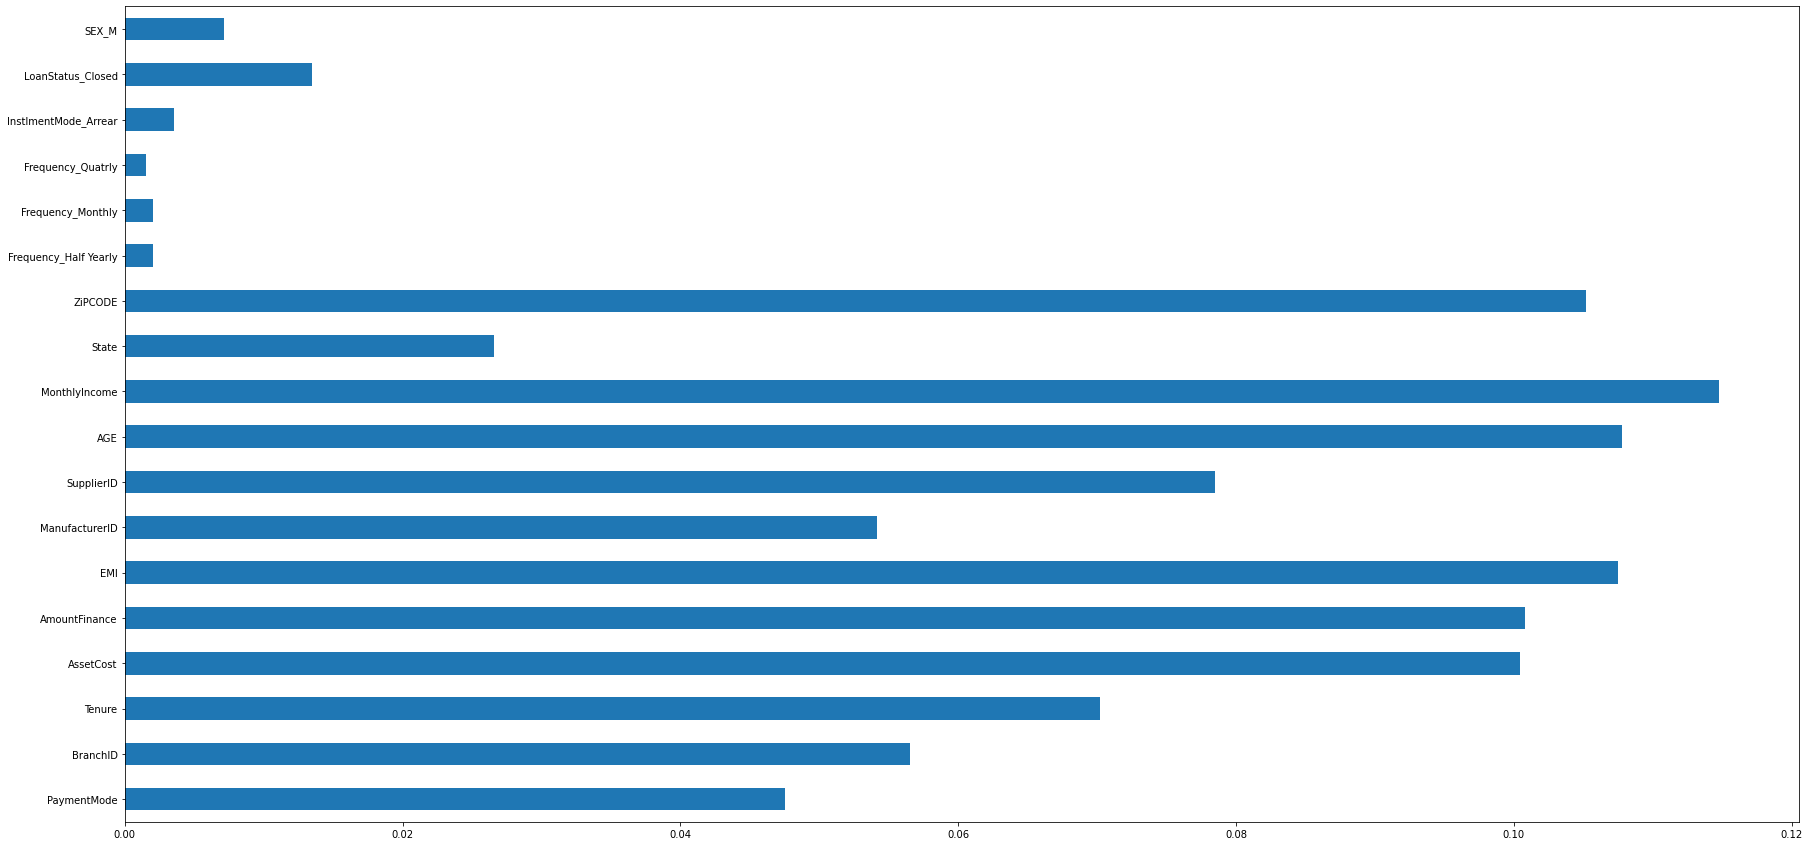

In [ ]:
feat_importances = pd.Series(model_feature_Selection.feature_importances_, index=dataset_only_independent.columns)
fig=plt.figure(figsize=[30,15])
feat_importances.plot(kind='barh')
plt.show()

In [ ]:
feat_importances.nlargest(10)

MonthlyIncome     0.114778
AGE               0.107828
EMI               0.107474
ZiPCODE           0.105223
AmountFinance     0.100789
AssetCost         0.100471
SupplierID        0.078514
Tenure            0.070220
BranchID          0.056544
ManufacturerID    0.054182
dtype: float64

In [ ]:
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2,k=10)
fit = bestfeatures.fit(dataset_only_independent,y_og_values)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(dataset_only_independent.columns)

# Concat two dataframes
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores

,Specs,Score
0,PaymentMode,1.124454e+03
1,BranchID,3.234023e+03
2,Tenure,9.111824e+03
3,AssetCost,1.943136e+07
4,AmountFinance,7.033055e+07
5,EMI,4.207183e+06
6,ManufacturerID,2.141100e+03
7,SupplierID,6.089623e+07
8,AGE,2.366357e+02
9,MonthlyIncome,1.310723e+07


In [ ]:
print(featureScores.nlargest(10,'Score'))

                Specs         Score
4       AmountFinance  7.033055e+07
7          SupplierID  6.089623e+07
11            ZiPCODE  2.833799e+07
3           AssetCost  1.943136e+07
9       MonthlyIncome  1.310723e+07
5                 EMI  4.207183e+06
2              Tenure  9.111824e+03
1            BranchID  3.234023e+03
16  LoanStatus_Closed  2.461276e+03
6      ManufacturerID  2.141100e+03


### Variance Threshold

In [ ]:
from sklearn.feature_selection import VarianceThreshold
var_thres = VarianceThreshold(threshold=0)
var_thres.fit(dataset_only_independent)
constant_columns = [column for column in dataset_only_independent.columns if column not in dataset_only_independent.columns[var_thres.get_support()]]
constant_columns

[]

In [ ]:
imp_features = ['MonthlyIncome','AGE','EMI','ZiPCODE','AmountFinance','AssetCost','SupplierID','Tenure','BranchID','ManufacturerID','LoanStatus_Closed']

In [ ]:
train_data = train_data[['top_up_class']+imp_features]
test_data = test_data[imp_features]
print(train_data.shape,test_data.shape)

(128654, 12) (14745, 11)


In [ ]:
train_data.head()

,top_up_class,MonthlyIncome,AGE,EMI,ZiPCODE,AmountFinance,AssetCost,SupplierID,Tenure,BranchID,ManufacturerID,LoanStatus_Closed
0,1,35833.33,49,24000.0,464993,275000.0,450000,21946,48,1,1568,1
1,0,666.67,23,10500.0,466001,350000.0,485000,34802,47,333,1062,1
2,6,45257.00,39,38300.0,462030,519728.0,690000,127335,68,1,1060,0
3,1,20833.33,24,11600.0,473335,400000.0,480000,25094,48,125,1060,1
4,2,27313.67,56,15000.0,495442,440000.0,619265,21853,44,152,1046,1


In [ ]:
y = train_data['top_up_class']
X = train_data.drop('top_up_class',axis=1)
print(X.shape,y.shape)

(128654, 11) (128654,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102923, 11) (25731, 11) (102923,) (25731,)


In [ ]:
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

In [ ]:
estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=1000)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------------------Logistic Regression------------------------
F1 Score 0.1303
Accuracy Score 0.827
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       0.00      0.00      0.00      1642
           2       0.00      0.00      0.00       761
           3       0.00      0.00      0.00       683
           4       1.00      0.00      0.00       663
           5       0.33      0.00      0.00       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.31      0.14      0.13     25731
weighted avg       0.72      0.83      0.75     25731



------------------------KNN------------------------
F1 Score 0.1475
Accuracy Score 0.8168
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     21279
           1       0.13      0.01      0.03    

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/train_final_mean_encoded_final_less_feat.xlsx')
test_data = pd.read_excel('/content/drive/MyDrive/LTFS_Top_up/test_final_mean_encoded_final_less_feat.xlsx')
print(train_data.shape,test_data.shape)

(128654, 20) (14745, 19)


In [ ]:
train_data = train_data.iloc[:,1:]
test_data = test_data.iloc[:,1:]
print(train_data.shape,test_data.shape)

(128654, 19) (14745, 18)


In [ ]:
train_data.head()

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
0,0.186877,1,48,450000,275000.0,24000.0,1568,21946,49,35833.33,0.425187,464993,1,0,1,0,1,1,1
1,0.255776,333,47,485000,350000.0,10500.0,1062,34802,23,666.67,0.425187,466001,0,0,1,0,0,1,1
2,0.668451,1,68,690000,519728.0,38300.0,1060,127335,39,45257.00,0.425187,462030,6,0,0,1,1,0,1
3,0.168888,125,48,480000,400000.0,11600.0,1060,25094,24,20833.33,0.425187,473335,1,0,1,0,0,1,1
4,0.168888,152,44,619265,440000.0,15000.0,1046,21853,56,27313.67,0.269824,495442,2,0,1,0,1,1,1


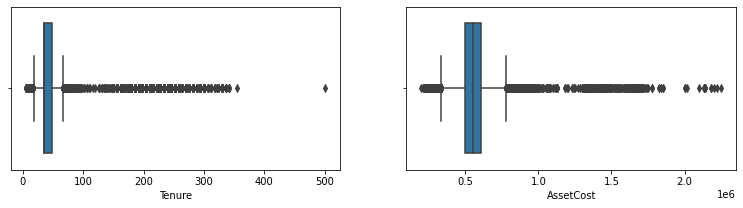

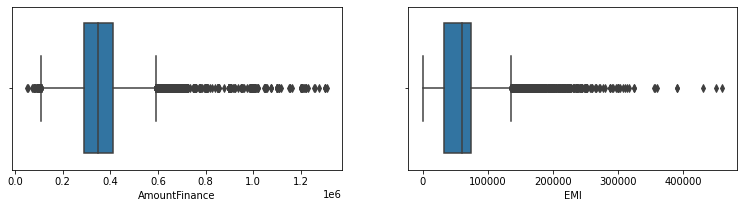

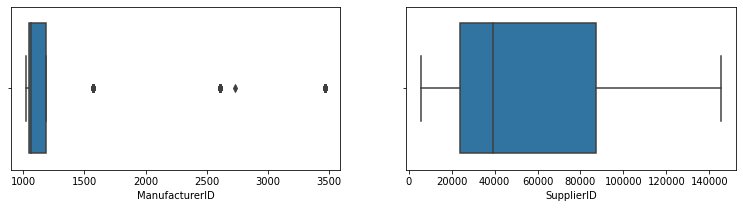

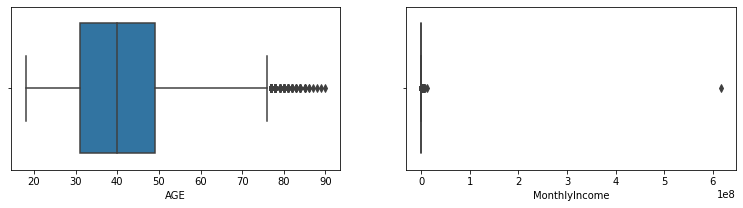

In [ ]:
num_cols = ['Tenure','AssetCost','AmountFinance','EMI','ManufacturerID','SupplierID','AGE','MonthlyIncome']
i=0
while i < 8:
    fig = plt.figure(figsize=[13,3])
    plt.subplot(1,2,1)
    sns.boxplot(x=num_cols[i], data=train_data)
    i += 1
    plt.subplot(1,2,2)
    sns.boxplot(x=num_cols[i], data=train_data)
    i += 1
    
    plt.show()

In [ ]:
def find_outlier_in_dataframe(list_of_features):
  for feature in list_of_features:
    print(feature,'\n')
    display(dataset[train_data[feature] > train_data[feature].quantile(0.99)])
    print('\n')

find_outlier_in_dataframe(num_cols)

Tenure 



,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
11,0.186877,5,240,675000,425000.00,40000.0,1187,21232,20,83333.33,0.269824,493116,0,1,0,0,1,1,1
791,0.255776,40,234,500000,350000.00,61690.0,1060,23549,48,14416.67,0.643566,500088,0,1,0,0,1,1,1
1116,0.255776,46,180,770000,483214.00,84565.0,1187,23740,37,97166.67,0.643566,508001,0,1,0,0,1,1,1
2029,0.168888,116,354,450000,320000.00,30000.0,1568,23962,33,8333.33,0.425187,464884,0,1,0,0,0,1,1
2086,0.168888,1,342,600000,400000.00,60000.0,1187,23135,41,37500.00,0.425187,463106,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85083,0.186877,298,210,500000,410000.00,65000.0,1568,40414,53,33333.33,0.425187,480111,0,1,0,0,1,1,1
85085,0.255776,298,210,500000,405000.00,64000.0,1568,40414,49,29166.67,0.425187,480111,0,1,0,0,1,1,1
85091,0.186877,294,186,580000,403839.00,68696.0,1019,35680,42,21166.67,0.185561,325206,0,1,0,0,1,1,1
90353,0.671169,73,186,610000,400000.00,90000.0,1186,106794,40,65350.00,0.388528,424305,0,1,0,0,1,0,1




AssetCost 



,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
16,0.186877,5,38,980000,700000.0,15000.0,1046,24760,57,36844.17,0.269824,493195,0,0,1,0,1,1,1
21,0.671169,5,36,1000000,640000.0,22580.0,1187,24275,35,116574.58,0.269824,493889,0,0,1,0,1,1,1
32,0.186877,5,54,812605,580000.0,10000.0,1046,24760,28,90833.33,0.269824,493889,0,0,0,1,1,1,1
36,0.186877,5,36,830000,600000.0,125000.0,1187,24275,49,41666.67,0.269824,493335,0,0,0,1,1,1,1
71,0.168888,8,36,1025000,500000.0,55420.0,1060,32105,40,66666.67,0.430084,756010,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121562,0.671169,39,60,880000,518000.0,75657.0,1568,91014,61,33333.33,0.436771,582203,0,1,0,0,1,0,1
123895,0.668451,150,63,840000,651160.0,15580.0,1568,126676,29,22000.00,0.425187,485001,2,0,1,0,1,0,1
125843,0.671169,423,48,803000,518000.0,45300.0,1568,130692,52,58333.33,0.607462,847224,0,0,0,1,1,0,1
125878,0.668451,270,60,868000,500000.0,76800.0,1568,83844,35,47666.67,0.607462,854206,4,1,0,0,1,0,1




AmountFinance 



,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
16,0.186877,5,38,980000,700000.0,15000.0,1046,24760,57,36844.17,0.269824,493195,0,0,1,0,1,1,1
21,0.671169,5,36,1000000,640000.0,22580.0,1187,24275,35,116574.58,0.269824,493889,0,0,1,0,1,1,1
30,0.255776,5,54,800000,665000.0,20000.0,1187,24275,21,55166.67,0.269824,493885,0,0,0,1,1,1,1
36,0.186877,5,36,830000,600000.0,125000.0,1187,24275,49,41666.67,0.269824,493335,0,0,0,1,1,1,1
790,0.668451,39,24,1600000,1043164.0,52340.0,1187,44630,40,35833.33,0.436771,580011,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127918,0.168888,328,60,800000,603145.0,95000.0,1568,23901,24,37500.00,0.269824,496445,1,1,0,0,1,0,1
127920,0.255776,328,24,800000,603199.0,300000.0,1568,23901,26,41666.67,0.269824,496445,0,1,0,0,1,1,1
128078,0.671169,334,60,720000,612754.0,93036.0,1568,75364,55,66500.00,0.436771,577428,0,1,0,0,1,0,1
128083,0.668451,334,71,745000,619827.0,95051.0,1568,87945,57,79166.67,0.436771,577416,0,1,0,0,1,0,0




EMI 



,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
14,0.255776,5,48,695000,450000.0,155000.0,1187,24275,45,116666.67,0.269824,492001,0,0,1,0,1,1,1
1436,0.186877,154,48,500000,425000.0,140000.0,1568,24082,25,23750.00,0.269824,493551,0,1,0,0,1,1,1
1866,0.668451,1,60,750000,653699.0,134000.0,1046,31231,27,32916.67,0.425187,462420,4,1,0,0,1,0,1
1886,0.668451,1,36,760000,560500.0,300000.0,1046,31231,56,49750.00,0.425187,462101,0,1,0,0,1,1,1
1895,0.671169,1,12,630000,300000.0,165520.0,1046,126304,54,73750.00,0.425187,464990,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127898,0.186877,328,18,700000,200000.0,200000.0,1568,23901,31,41666.67,0.269824,496445,0,1,0,0,1,1,1
127902,0.255776,328,24,420000,289746.0,150700.0,1568,23901,27,25000.00,0.269824,496445,0,1,0,0,1,1,1
127915,0.255776,328,24,650000,476709.0,200000.0,1568,23901,38,20250.00,0.269824,496445,0,1,0,0,1,1,1
127920,0.255776,328,24,800000,603199.0,300000.0,1568,23901,26,41666.67,0.269824,496445,0,1,0,0,1,1,1




ManufacturerID 



,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
19763,0.668451,32,33,467000,153977.0,23144.0,2608,112385,23,53333.33,0.436771,562110,0,0,0,1,1,0,1
19766,0.668451,32,24,305023,113271.0,17033.0,2608,112385,29,45000.00,0.436771,562129,0,0,0,1,1,1,1
20048,0.668451,33,60,430000,300000.0,48760.0,3473,110014,25,70833.33,0.436771,586115,0,1,0,0,1,0,1
20745,0.668451,38,24,380000,206644.0,30800.0,3473,139780,41,62500.00,0.643566,516217,0,0,0,1,1,1,0
20756,0.668451,38,24,410905,210434.0,10225.0,2608,140500,31,33333.33,0.643566,516203,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83112,0.255776,55,48,1659683,1000000.0,180000.0,2733,22094,55,83333.33,0.289552,382433,0,1,0,0,1,1,1
85178,0.255776,300,36,336000,200132.0,44407.0,2608,103410,47,25000.00,0.436771,577518,0,1,0,0,1,1,1
85264,0.671169,33,36,410000,249000.0,56100.0,3473,110014,44,58333.33,0.436771,586119,0,1,0,0,1,0,1
85277,0.168888,33,48,330000,249000.0,45629.0,3473,110014,43,26666.67,0.436771,586101,0,1,0,0,1,1,0




SupplierID 



,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
4147,0.671169,3,36,535000,413404.0,86600.0,1046,137841,60,10062.50,0.425187,483225,5,1,0,0,1,0,1
4148,0.668451,3,36,530000,313196.0,65200.0,1046,137841,46,48916.67,0.425187,483225,0,1,0,0,1,0,1
4149,0.668451,3,36,530000,306308.0,63750.0,1046,137841,54,38000.00,0.425187,483225,5,1,0,0,1,0,1
4154,0.668451,3,36,515000,265929.0,55250.0,1046,137841,22,8000.00,0.425187,483336,0,1,0,0,1,0,1
4155,0.671169,3,36,650000,355736.0,82000.0,1046,137841,51,86000.00,0.425187,483222,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128615,0.671169,401,24,500000,201888.0,60095.0,1568,139867,52,33666.67,0.425187,484001,5,1,0,0,1,0,1
128616,0.668451,401,39,500000,265887.0,65454.0,1568,139867,26,25333.33,0.425187,484001,5,1,0,0,1,0,1
128622,0.255776,412,29,490000,200000.0,30000.0,1568,138749,66,36666.67,0.332065,209728,0,0,0,1,1,0,1
128643,0.668451,414,24,450000,300000.0,85500.0,1568,139068,24,141666.67,0.533554,121103,0,1,0,0,1,1,1




AGE 



,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
250,0.168888,9,35,640270,350000.0,12415.0,1046,24390,81,17083.33,0.385640,712614,0,0,1,0,0,1,1
253,0.168888,10,35,537092,218000.0,7735.0,1019,22934,75,144000.00,0.385640,713144,0,0,1,0,0,1,1
1383,0.186877,148,36,512000,300000.0,33000.0,1186,41213,70,41666.67,0.387383,151203,0,0,0,1,1,1,1
1394,0.255776,148,48,310000,250000.0,22300.0,1568,90389,73,54166.67,0.387383,151301,0,0,0,1,1,1,1
1861,0.668451,1,36,570000,300000.0,20000.0,1046,31231,71,99166.67,0.425187,463111,4,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127374,0.255776,310,36,485000,300000.0,30000.0,1568,40436,70,16666.67,0.289552,383270,0,1,0,0,1,1,1
127591,0.671169,318,60,610000,400000.0,60000.0,1568,35151,70,41666.67,0.289552,362560,4,1,0,0,1,0,1
127592,0.671169,318,65,615000,510000.0,79000.0,1568,35151,70,37500.00,0.289552,362510,4,1,0,0,1,0,0
127594,0.668451,318,48,570000,430000.0,78000.0,1568,35151,70,33333.33,0.289552,362150,0,1,0,0,1,0,1




MonthlyIncome 



,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
18,0.168888,152,33,354000,290000.0,63000.0,1568,20374,27,290000.00,0.269824,495224,0,0,1,0,1,1,1
403,0.668451,10,53,713765,460000.0,13500.0,1019,102398,26,370000.00,0.385640,731103,0,0,1,0,1,1,1
971,0.668451,57,48,500000,430000.0,37300.0,1046,23912,36,233333.33,0.289552,391310,0,0,0,1,1,1,1
995,0.168888,59,48,495000,400563.0,11450.0,1046,44670,25,350000.00,0.289552,370421,4,0,1,0,1,1,1
1006,0.186877,59,23,430000,340000.0,16940.0,1046,44222,48,250000.00,0.289552,370001,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128261,0.671169,341,37,500000,351319.0,74830.0,1568,104434,29,411300.00,0.185561,322025,0,1,0,0,1,0,1
128347,0.255776,342,60,550000,450000.0,25000.0,1568,89502,27,425000.00,0.425187,486226,0,1,0,0,1,1,1
128452,0.671169,359,24,420000,302361.0,15200.0,1568,141470,52,600000.00,0.332065,276001,6,0,1,0,1,0,0
128519,0.668451,376,36,350000,260000.0,20000.0,1568,24032,24,715000.00,0.533554,124507,0,1,0,0,1,1,1


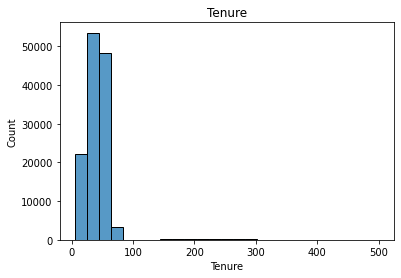

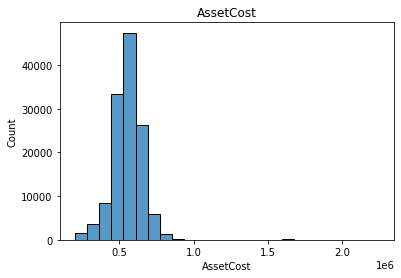

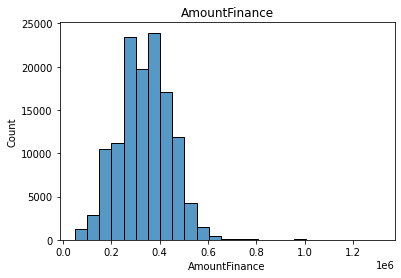

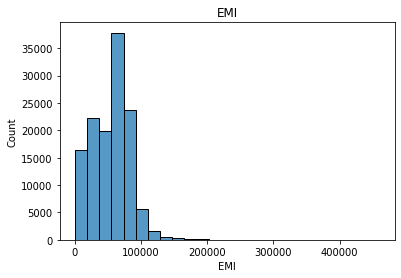

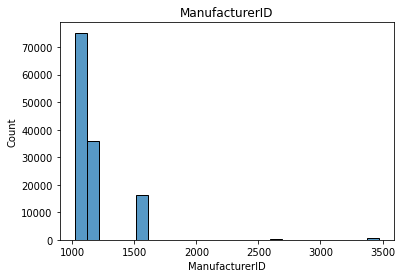

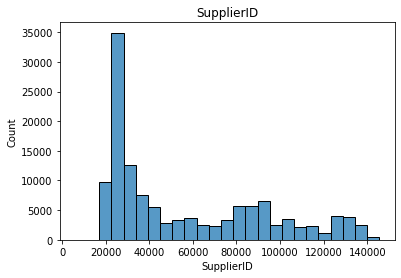

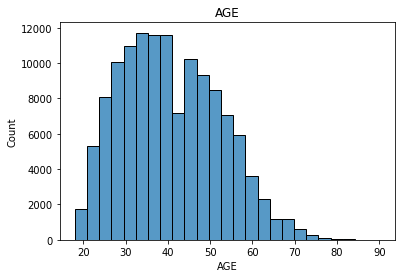

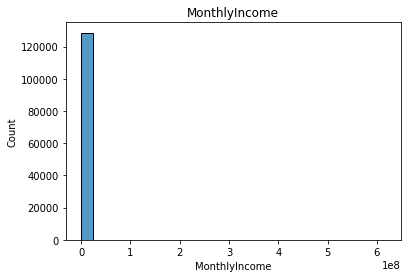

In [ ]:
for feature in num_cols:
    data =dataset.copy()
    #data[feature].hist(bins=25)
    sns.histplot(x=feature,data=train_data,bins=25)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

In [ ]:
def lower_upper_not_normal_outlier(features):
  for feature in features:
    iqr = train_data[feature].quantile(0.75) - train_data[feature].quantile(0.25)
    lower_bridge = train_data[feature].quantile(0.25) - (iqr * 3)
    upper_bridge = train_data[feature].quantile(0.75) + (iqr * 3)
    print(feature,'\n')
    print('Lower Extreme Value : ',lower_bridge) , print('Upper Extreme Value : ',upper_bridge)
    print('\n')

lower_upper_not_normal_outlier(num_cols)

Tenure 

Lower Extreme Value :  0.0
Upper Extreme Value :  84.0


AssetCost 

Lower Extreme Value :  167000.0
Upper Extreme Value :  944000.0


AmountFinance 

Lower Extreme Value :  -70000.0
Upper Extreme Value :  770000.0


EMI 

Lower Extreme Value :  -91400.0
Upper Extreme Value :  197700.0


ManufacturerID 

Lower Extreme Value :  626.0
Upper Extreme Value :  1606.0


SupplierID 

Lower Extreme Value :  -164730.0
Upper Extreme Value :  275857.0


AGE 

Lower Extreme Value :  -23.0
Upper Extreme Value :  103.0


MonthlyIncome 

Lower Extreme Value :  -50000.0
Upper Extreme Value :  125000.0




In [ ]:
train_data.head()

,PaymentMode,BranchID,Tenure,AssetCost,AmountFinance,EMI,ManufacturerID,SupplierID,AGE,MonthlyIncome,State,ZiPCODE,top_up_class,Frequency_Half Yearly,Frequency_Monthly,Frequency_Quatrly,InstlmentMode_Arrear,LoanStatus_Closed,SEX_M
0,0.186877,1,48,450000,275000.0,24000.0,1568,21946,49,35833.33,0.425187,464993,1,0,1,0,1,1,1
1,0.255776,333,47,485000,350000.0,10500.0,1062,34802,23,666.67,0.425187,466001,0,0,1,0,0,1,1
2,0.668451,1,68,690000,519728.0,38300.0,1060,127335,39,45257.00,0.425187,462030,6,0,0,1,1,0,1
3,0.168888,125,48,480000,400000.0,11600.0,1060,25094,24,20833.33,0.425187,473335,1,0,1,0,0,1,1
4,0.168888,152,44,619265,440000.0,15000.0,1046,21853,56,27313.67,0.269824,495442,2,0,1,0,1,1,1


In [ ]:
train_data.loc[train_data['Tenure'] > 84 , 'Tenure'] = 84
train_data.loc[train_data['AssetCost'] > 944000 , 'AssetCost']=944000
train_data.loc[train_data['AmountFinance'] > 770000.0 , 'AmountFinance'] = 770000.0
train_data.loc[train_data['EMI'] > 197700.0 , 'EMI']=197700.0
train_data.loc[train_data['ManufacturerID'] > 1606 , 'ManufacturerID'] = 1606
train_data.loc[train_data['SupplierID'] > 275857 , 'SupplierID']=275857
train_data.loc[train_data['AGE'] > 103 , 'AGE'] = 103
train_data.loc[train_data['MonthlyIncome'] > 125000.0 , 'MonthlyIncome']=125000.0

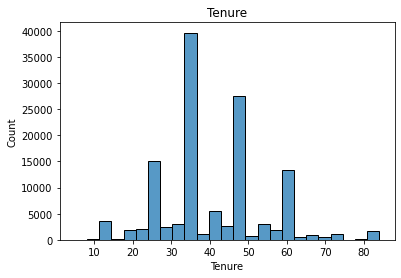

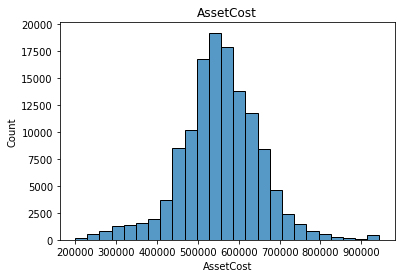

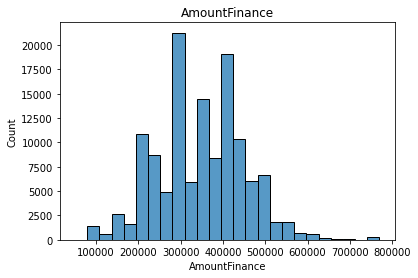

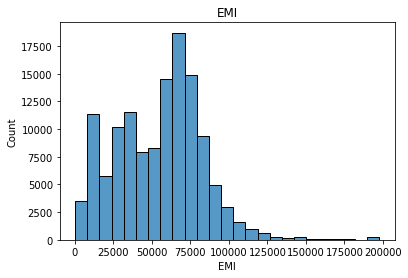

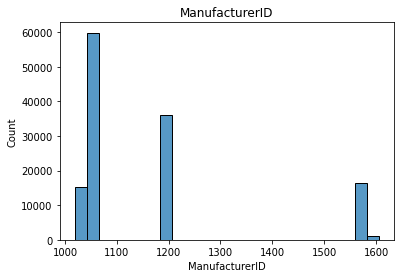

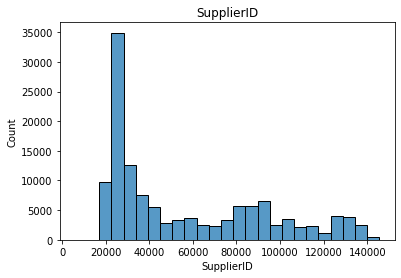

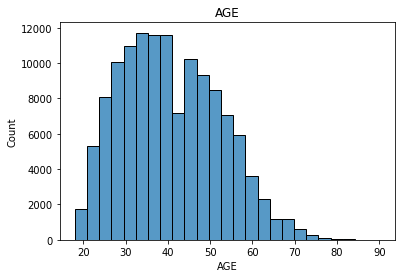

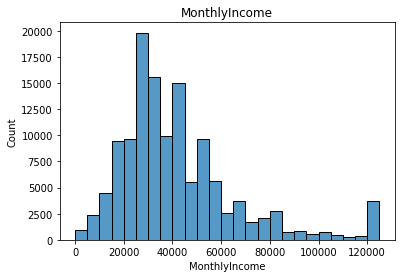

In [ ]:
for feature in num_cols:
    data =dataset.copy()
    #data[feature].hist(bins=25)
    sns.histplot(x=feature,data=train_data,bins=25)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

Tenure 



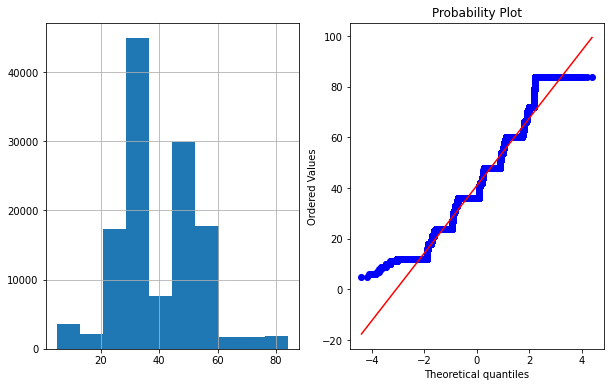



AssetCost 



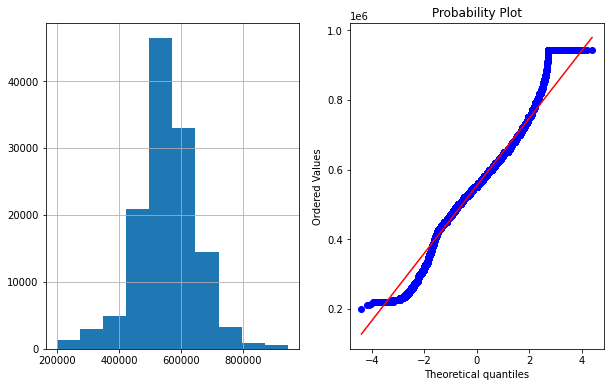



AmountFinance 



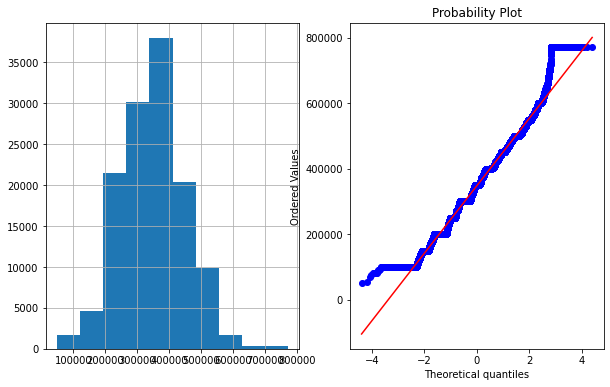



EMI 



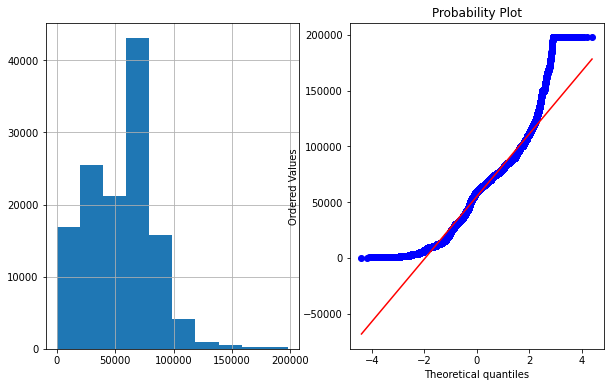



ManufacturerID 



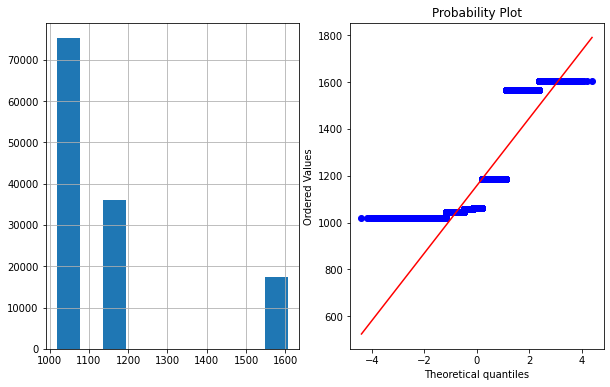



SupplierID 



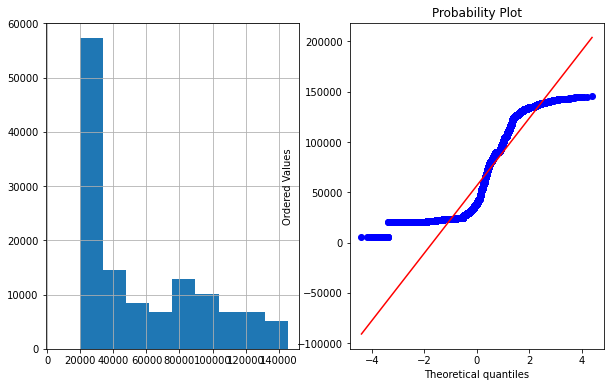



AGE 



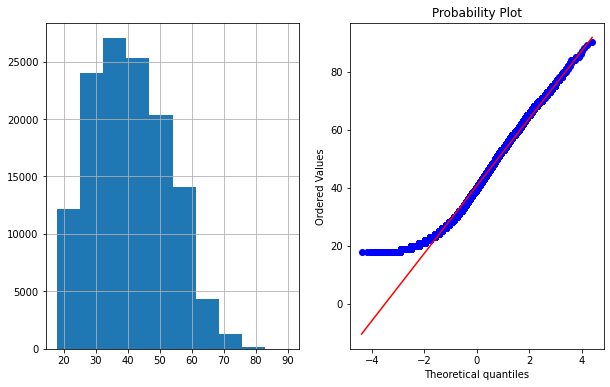



MonthlyIncome 



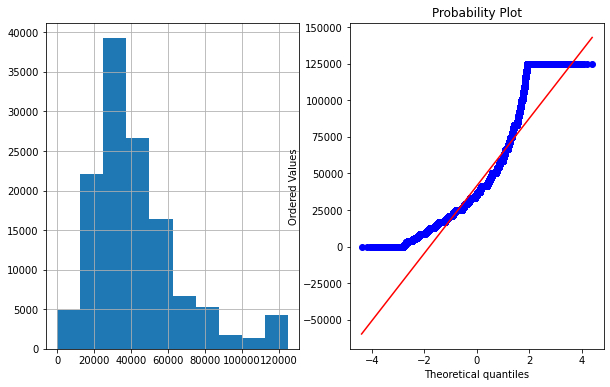

In [ ]:
import scipy.stats as stat
import pylab
def plot_data(df,features):
  for feature in features:
    print(feature , '\n')
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()
    print('\n')
plot_data(train_data,num_cols)

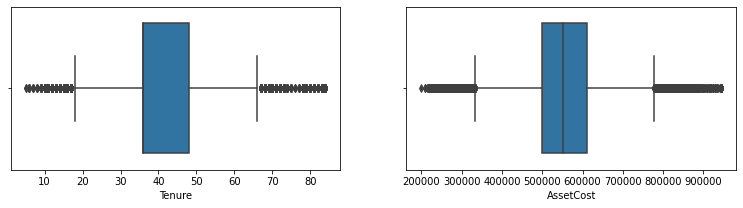

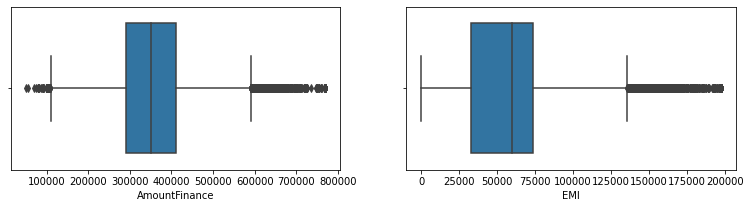

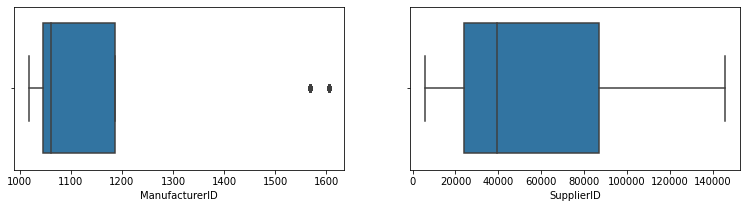

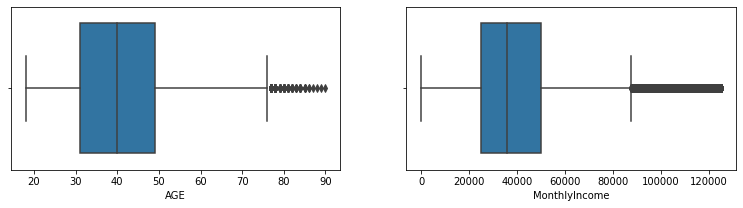

In [ ]:
num_cols = ['Tenure','AssetCost','AmountFinance','EMI','ManufacturerID','SupplierID','AGE','MonthlyIncome']
i=0
while i < 8:
    fig = plt.figure(figsize=[13,3])
    plt.subplot(1,2,1)
    sns.boxplot(x=num_cols[i], data=train_data)
    i += 1
    plt.subplot(1,2,2)
    sns.boxplot(x=num_cols[i], data=train_data)
    i += 1
    
    plt.show()

In [ ]:
y = train_data['top_up_class']
X = train_data.drop('top_up_class',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)


estimators_st = {
    'Logistic Regression': [LogisticRegression()],
    'KNN' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boosting':[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
    'LGBM':[LGBMClassifier()],
    'Cat Boost':[CatBoostClassifier(verbose=0, n_estimators=1000)],
}

#writing a function to fit models above to the train dataset
def mfit(estimators_st, X_train, y_train):
    for m in estimators_st:
        estimators_st[m][0].fit(X_train, y_train)
        print(m+' fitted')

mfit(estimators_st, X_train_st, y_train)

def mpredict(estimators_st, X_test_st, y_test):
    outcome = dict()
    for m in estimators_st:
        y_pred = estimators_st[m][0].predict(X_test_st)
        outcome[m] = [metrics.f1_score(y_test,y_pred,average='macro'),
                      metrics.accuracy_score(y_test,y_pred),
                      metrics.classification_report(y_test,y_pred)]
    return outcome


outcome_st = mpredict(estimators_st, X_test_st, y_test)

for m in outcome_st:
    print('------------------------'+m+'------------------------')
    print('F1 Score', round(outcome_st[m][0],4))
    print('Accuracy Score', round(outcome_st[m][1],4))
    print('Classification report \n ')
    print(outcome_st[m][2])
    print('\n')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression fitted
KNN fitted
Decision Tree fitted
Random Forest fitted
Gradient Boosting fitted
XG Boost fitted
LGBM fitted
Cat Boost fitted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classificat

------------------------Logistic Regression------------------------
F1 Score 0.1299
Accuracy Score 0.8267
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     21279
           1       0.00      0.00      0.00      1642
           2       0.00      0.00      0.00       761
           3       0.00      0.00      0.00       683
           4       0.00      0.00      0.00       663
           5       0.20      0.00      0.00       502
           6       0.00      0.00      0.00       201

    accuracy                           0.83     25731
   macro avg       0.15      0.14      0.13     25731
weighted avg       0.69      0.83      0.75     25731



------------------------KNN------------------------
F1 Score 0.1594
Accuracy Score 0.8172
Classification report 
 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     21279
           1       0.23      0.04      0.07   